In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

import pysam

from itertools import cycle
color_cycle = cycle(['r', 'g', 'b', 'orange'])
FS = 12 # fontsize

In [2]:
def read_fast5(fname, single_or_multi_read, get_read_ids=False):
    'from !bsc_szakdoga/github/python_scripts/fast5_analysis.ipynb'
    from ont_fast5_api.fast5_interface import get_fast5_file
    def raw_to_current(rawdata, offset, range_, digitisation):
        return list((np.array(rawdata) + offset) * range_ / digitisation)
    
    if single_or_multi_read not in ['s', 'm']:
        raise ValueError('single_or_multi variable must be "s" or "m".')
    data = []
    read_ids = []
    with get_fast5_file(fname, mode="r") as f:
        for read in f.get_reads():
            ch=read.get_channel_info()
            data.append(raw_to_current(read.get_raw_data(), ch['offset'], ch['range'], ch['digitisation']))
            read_ids.append(read.read_id)
    if single_or_multi_read == 's':
        if get_read_ids:
            return np.array(data[0]), read_ids
        return np.array(data[0]) # single read --> dim=1
    elif single_or_multi_read == 'm':
        if get_read_ids:
            return np.array(data, dtype='object'), read_ids
        return np.array(data, dtype='object')
    
def read_sam_mvt(sam_file_names): 
    ''' read sam file with move table '''
    if  type(sam_file_names) != list:
        raise TypeError(f'sam_file_names must be a list')
    all_sam_data = []
    for sam_file_name in sam_file_names:
        with open(sam_file_name, 'r') as file:
            sam_files = file.read().split('\n')
            sam_files = [line for line in sam_files if not line.startswith('@')]
        one_sam_data = []
        for i in range(len(sam_files)-1):
            sam = sam_files[i].split('\t')
            data = {
                'read_id': sam[0],
                'bases': np.array(list(sam[9])), # splitted to characters,
                'move_table':  np.array(sam[11].split(',')[2:], dtype='int'),
                'stride': int(sam[11].split(',')[1]),
                'ts': int(sam[19][5:]),
                'fast5_file_name': sam[17][5:]
                }
            one_sam_data.append(data)
        all_sam_data.append(np.array(one_sam_data, dtype='object'))
    return np.hstack(all_sam_data)

def read_sam_pos(sam_file_names): 
    ''' read sam file with position '''
    if  type(sam_file_names) != list:
        raise TypeError(f'sam_file_names must be a list')
    all_sam_data = []
    for sam_file_name in sam_file_names:
        with open(sam_file_name, 'r') as file:
            sam_files = file.read().split('\n')
            sam_files = [line for line in sam_files if not line.startswith('@')]
        one_sam_data = []
        for i in range(len(sam_files)-1):
            sam = sam_files[i].split('\t')
            data = {
                'read_id':sam[0], 
                'sam_flag':int(sam[1]),
                'mapped_position':int(sam[3]),
                'map_quality':int(sam[4]),
                'sequence':np.array(list(sam[9])),
                'mismatches_and_gaps': int(sam[11][5:]),
               } 
            one_sam_data.append(data)
        all_sam_data.append(np.array(one_sam_data, dtype='object'))
    return np.hstack(all_sam_data)

def find_read_id_index(string_list, search_string):
    string_array = np.array(string_list)
    index = np.where(np.char.find(string_array, search_string) != -1)[0]
    if len(index) == 1:
        return index[0]
    print(f'Error: no or more indices found; len(index)={len(index)}')
    return None

def split_raw_signal(raw_signal, move_table, stride):
    start_of_bases = (np.where(move_table == 1)[0]) * stride
    signals = [raw_signal[i:j] for i, j in zip(start_of_bases, start_of_bases[1:])]
    mean_signals = [np.mean(raw_signal[i:j]) for i, j in zip(start_of_bases, start_of_bases[1:])]
    return start_of_bases, signals, mean_signals

def replace_T_to_U(data):
    if  type(data) not in [list, np.ndarray]:
        raise TypeError(f'sam_file_names must be a list')
    for record in data:
        record['bases'] = np.array(['U' if base == 'T' else base for base in record['bases']])
    return np.array(data)

def get_feature_from_sam_data(data, feature):
    return np.array([entry[feature] for entry in data ], dtype='object')

def search_in_data(data, key, element):
    for entry in data:
        if entry[key] == element:
            return entry
    return None

In [3]:
def join_datasets(arr1, arr2):
    dict1 = {d['read_id']: d for d in arr1}
    dict2 = {d['read_id']: d for d in arr2}
    
    # Intersect keys and merge dictionaries
    result = [
        {**dict1[read_id], **dict2[read_id]}
        for read_id in dict1.keys() & dict2.keys()
    ]
    return np.array(result, dtype=object)

def read_sam_files(sam_mvt, sam_pos, min_length=0, max_length=1e5, min_MAPQ=0, max_MISMATCHES=1e5,
                   removed_sam_flags={4, 256, 272, 2048, 2064}):

    if  type(sam_mvt) != list and type(sam_pos) != list:
        raise TypeError(f'sam_mvt and/or sam_pos must be a list')
    all_sam_data = []
    for sam_mvt_file_name, sam_pos_file_name in zip(sam_mvt, sam_pos):
        with open(sam_mvt_file_name, 'r') as mvt, open(sam_pos_file_name, 'r') as pos:
            sam_mvt_files = mvt.read().split('\n')[:-1]
            sam_mvt_files = [line for line in sam_mvt_files if not line.startswith('@')]
            sam_pos_files = pos.read().split('\n')[:-1]
            sam_pos_files = [line for line in sam_pos_files if not line.startswith('@')]

        one_sam_mwt_data = []
        for item in sam_mvt_files:
            sam = item.split('\t')
            data = {
                'read_id': sam[0],
                'bases': np.array(list(sam[9])), # splitted to characters,
                'move_table':  np.array(sam[11].split(',')[2:], dtype='int'),
                'stride': int(sam[11].split(',')[1]),
                'ts': int(sam[19][5:]),
                'fast5_file_name': sam[17][5:]
                }
            if len(data['bases']) <= max_length and len(data['bases']) >= min_length:
                one_sam_mwt_data.append(data)
        
        one_sam_pos_data = []
        for item in sam_pos_files:
            sam = item.split('\t')
            data = {
                'read_id':sam[0], 
                'sam_flag':int(sam[1]),
                'mapped_position':int(sam[3]),
                'map_quality':int(sam[4]),
                'mismatches_and_gaps': int(sam[11][5:]),
               } 
            if data['sam_flag'] not in removed_sam_flags and data['map_quality'] >= min_MAPQ and data['mismatches_and_gaps']<max_MISMATCHES:
                one_sam_pos_data.append(data)

        all_sam_data.append(join_datasets(one_sam_mwt_data, one_sam_pos_data))
    return np.hstack(all_sam_data)


---
# Reference file

In [4]:
with open("/v/volumes/nanopore/ref/p300_ID3.fasta", 'r') as file:
    p300_ID3_ref = file.read().split('\n')[1]

---
# Thymine

In [5]:
path_to_Thymine_fast5 = '/v/projects/nanopore/agnes/signal_visualization/data/timin0421/workspace/'
T_fast5_files = glob(path_to_Thymine_fast5+'*.fast5')

path_to_Thymine_sam_mvt = '/v/projects/nanopore/balazs/data/thymine_0421_sam_move_table/'
T_sam_mvt_files = glob(path_to_Thymine_sam_mvt+'*0.sam')
T_sam_mvt_files = sorted(T_sam_mvt_files, key=lambda x: int(re.search(r'_(\d+)_0\.sam$', x).group(1)))

path_to_Thymine_sam_pos = '/v/projects/nanopore/balazs/data/thymine_0421_sam_position/'    
T_sam_pos_files = glob(path_to_Thymine_sam_pos+'*0.sam')
T_sam_pos_files = sorted(T_sam_pos_files, key=lambda x: int(re.search(r'_(\d+)_0\.sam$', x).group(1)))

In [6]:
%%time
T_sam_data = read_sam_files(T_sam_mvt_files, T_sam_pos_files, 
                            min_length=len(p300_ID3_ref)*0.2,
                            max_length=len(p300_ID3_ref)*1.1,
                            min_MAPQ=35,
                            max_MISMATCHES=len(p300_ID3_ref)*0.05,
                           )
# Wall time: ~12 s

CPU times: user 12.3 s, sys: 468 ms, total: 12.7 s
Wall time: 12.7 s


In [7]:
T_sam_data.shape

(10822,)

In [8]:
list1 = get_feature_from_sam_data(T_sam_data, 'read_id')
len(list1)

10822

In [9]:
idx=137

In [10]:
T_sam_data[idx]

{'read_id': '5b7d1749-3065-4269-8265-bf7f3535a9f9',
 'bases': array(['T', 'A', 'A', ..., 'T', 'A', 'T'], dtype='<U1'),
 'move_table': array([1, 1, 0, ..., 0, 0, 1]),
 'stride': 5,
 'ts': 0,
 'fast5_file_name': 'aoa546_pass_235c7b69_db4f2d16_18.fast5',
 'sam_flag': 16,
 'mapped_position': 3,
 'map_quality': 60,
 'mismatches_and_gaps': 49}

In [11]:
bases = T_sam_data[idx]['bases']
map_pos=T_sam_data[idx]['mapped_position']-1

In [12]:
ref_seq = np.array(list(p300_ID3_ref))[map_pos:] 

In [13]:
sum(ref_seq == bases[:len(ref_seq)])/len(ref_seq)

0.22719449225473323

---

In [14]:
T_sam_pos_data = read_sam_pos(T_sam_pos_files)
possible_positions = get_feature_from_sam_data(T_sam_pos_data, 'mapped_position')

In [15]:
len(possible_positions)

21418

In [16]:
sum(possible_positions == 0)

194

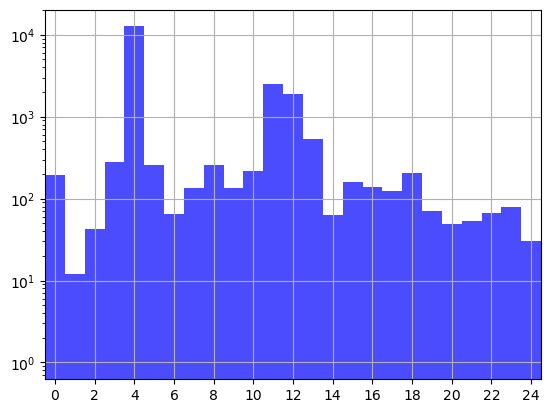

In [17]:
xlim_min=0
xlim_max=25

plt.hist(possible_positions, bins=max(possible_positions), color='blue', alpha=0.7)
plt.yscale('log')
plt.xlim(xlim_min, xlim_max)
plt.grid('dotted')
plt.xticks(np.arange(xlim_min, xlim_max, 2)+0.5, np.arange(xlim_min, xlim_max, 2))
plt.show()

----

In [18]:
T_sam_mvt_data = read_sam_mvt(T_sam_mvt_files)

In [19]:
mapped_position = T_sam_pos_data[0]['mapped_position']
sequence = T_sam_pos_data[0]['sequence']

In [20]:
mapped_position

4

In [21]:
T_sam_pos_data.shape

(21418,)

In [22]:
x1 = search_in_data(T_sam_pos_data, 'read_id', '00e098be-804c-4204-bfad-c4f6867ae265')
x2 = search_in_data(T_sam_mvt_data, 'read_id', '00e098be-804c-4204-bfad-c4f6867ae265')

In [23]:
x2

{'read_id': '00e098be-804c-4204-bfad-c4f6867ae265',
 'bases': array(['C', 'T', 'T', ..., 'T', 'A', 'A'], dtype='<U1'),
 'move_table': array([1, 1, 0, ..., 1, 0, 0]),
 'stride': 5,
 'ts': 95,
 'fast5_file_name': 'aoa546_pass_235c7b69_db4f2d16_2.fast5'}

In [24]:
x1

{'read_id': '00e098be-804c-4204-bfad-c4f6867ae265',
 'sam_flag': 16,
 'mapped_position': 6,
 'map_quality': 60,
 'sequence': array(['T', 'T', 'A', ..., 'A', 'A', 'G'], dtype='<U1'),
 'mismatches_and_gaps': 40}

----

In [25]:
# Read fast5 file


= read_fast5(fast5_file_path, 'm', get_read_ids=True)

---
# Uracil

In [26]:
path_to_Uracil_fast5 = '/v/projects/nanopore/agnes/signal_visualization/uracil0504/guppy/workspace/'
U_fast5_files = glob(path_to_Uracil_fast5+'*.fast5')


path_to_Uracil_sam_mvt = '/v/projects/nanopore/balazs/data/uracil_0405_sam_move_table/'
U_sam_mtv_files = glob(path_to_Uracil_sam_mvt+'*0.sam')
U_sam_mtv_files = sorted(U_sam_mtv_files, key=lambda x: int(re.search(r'_(\d+)_0\.sam$', x).group(1)))

In [27]:
# Read SAM file and fast5 file
U_sam_mvt_data = read_sam_mvt([U_sam_mtv_files[5]])
index_of_fast5 = 0
fast5_file_path = path_to_Uracil_fast5 + U_sam_mvt_data[index_of_fast5]['fast5_file_name']
fast5_signals, read_ids = read_fast5(fast5_file_path, 'm', get_read_ids=True)

In [28]:
# Replace thymine to uracil
U_sam_mvt_data = replace_T_to_U(U_sam_mvt_data)

In [29]:
all_bases_U = get_feature_from_sam_data(U_sam_mvt_data, 'bases')

all_bases_length_U = []
for item in all_bases_U:
    all_bases_length_U.append(len(item))

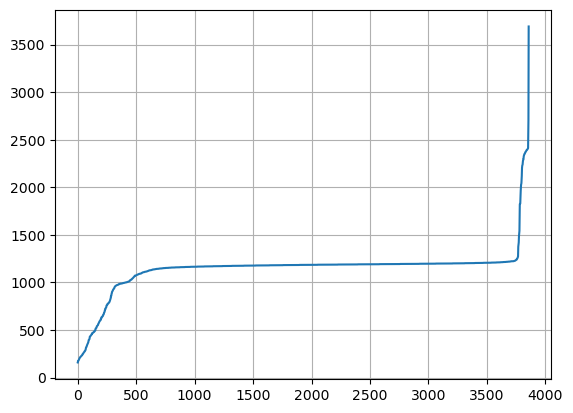

In [30]:
plt.plot(sorted(all_bases_length_U))
plt.grid()